In [1]:
import requests
import zipfile
import os
import torch
from tqdm import trange,tqdm
import torch.nn as nn
import torch.optim as optim
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from csv import reader
cur_device = "cuda" # change this to your favorite device, or "cpu" if you're not sure

In [2]:
# download UCI power consumption dataset from website
URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip'
response = requests.get(URL)
open('household_power_consumption.zip', 'wb').write(response.content)
with zipfile.ZipFile('household_power_consumption.zip','r') as zip_ref:
    zip_ref.extractall(os.getcwd())
os.remove('household_power_consumption.zip')
# remove the first line from the txt file corresponding to column titles
with open('household_power_consumption.txt', 'r') as fin:
    data = fin.read().splitlines(True)
with open('household_power_consumption.txt', 'w') as fout:
    fout.writelines(data[1:])

In [3]:
# replace semicolons with commas in the downloaded text file
with open('household_power_consumption.txt', 'r') as file :
    filedata = file.read()
filedata = filedata.replace(';', ',')
with open('household_power_consumption.txt', 'w') as file:
    file.write(filedata)

# read data into a list of lists
with open('household_power_consumption.txt', 'r') as read_obj:
    csv_reader = reader(read_obj)
    list_of_rows = list(csv_reader)
    
# append first two columns (date + time)
list_of_rows = [[x[0]+','+x[1]]+x[2:] for x in list_of_rows]

In [4]:
# get datetime object of first entr
init_time = list_of_rows[0][0] # initial time for dataset
init_time_obj = datetime.strptime(init_time,"%d/%m/%Y,%H:%M:%S")

# rewrite list in terms of time deltas in seconds
list_of_rows = [[(datetime.strptime(x[0],"%d/%m/%Y,%H:%M:%S")-init_time_obj).total_seconds()]+x[1:] for x in list_of_rows]

# convert to numpy
data = np.array(list_of_rows)

In [5]:
# extract data for all three submeterings
X_sm_1 = data[:,5]
X_sm_2 = data[:,6]
X_sm_3 = data[:,7]

In [6]:
# function to clean up numpy arrays with strings
def clean_np(x,chars):
    for charx in chars:
        x = np.where(x==charx,0,x)
    return x.astype(np.float32)

In [7]:
# sort data into X_train and y_train
in_size = 10
out_size = 5
X_sm_1_list = list(X_sm_1)
X_sm_2_list = list(X_sm_2)
for i in tqdm(range(X_sm_1.shape[0]-in_size-out_size)):
    if i == 0:
        X_train = [X_sm_1[i:in_size]]
        Y_train = [X_sm_1[i+in_size:i+in_size+out_size]]
        X_val = [X_sm_2[i:in_size]]
        Y_val = [X_sm_2[i+in_size:i+in_size+out_size]]
    else:
        X_train.append(X_sm_1[i:i+in_size])
        Y_train.append(X_sm_1[i+in_size:i+in_size+out_size])
        X_val.append(X_sm_2[i:i+in_size])
        Y_val.append(X_sm_2[i+in_size:i+in_size+out_size])
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_val= np.array(X_val)
Y_val = np.array(Y_val)
# remove strings
X_train = clean_np(X_train,['?',''])
Y_train = clean_np(Y_train,['?',''])
X_val = clean_np(X_val,['?',''])
Y_val = clean_np(Y_val,['?',''])


100%|██████████| 2075244/2075244 [00:02<00:00, 829421.77it/s]


In [8]:
# try a simple sequential model first
seq_model = nn.Sequential(
    nn.Linear(in_size,5*in_size),
    nn.Tanh(),
    nn.Linear(5*in_size,3*out_size),
    nn.PReLU(),
    nn.Linear(3*out_size,out_size)
)

In [9]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3)
n_epochs = 20000
loss_fn = nn.MSELoss()
losses = []
losses_val = []
BS = 512 # batch size
VS = 1024 # validation size
device = torch.device(cur_device)
X_train_t = torch.from_numpy(X_train.astype(np.float32)).to(device)
Y_train_t = torch.from_numpy(Y_train.astype(np.float32)).to(device)
seq_model = seq_model.to(device)

# create val dataset
X_val_t = torch.from_numpy(X_val.astype(np.float32)).to(device)
Y_val_t = torch.from_numpy(Y_val.astype(np.float32)).to(device)
samp_val = np.random.randint(0,X_val.shape[0],(VS))
X_val = X_val_t[samp_val,:]
Y_val = Y_val_t[samp_val]

for i in (t:=trange(n_epochs)):
    samp = np.random.randint(0,X_train.shape[0],(BS))
    X = X_train_t[samp,:]
    Y = Y_train_t[samp]
    out = seq_model(X)
    loss = loss_fn(out,Y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    t.set_description('loss %.3f' % (loss.item()))
    losses.append(loss.item())
    # calculate valudation losses
    losses_val.append(loss_fn(seq_model(X_val),Y_val).item())

loss 10.754: 100%|██████████| 20000/20000 [00:39<00:00, 510.19it/s]


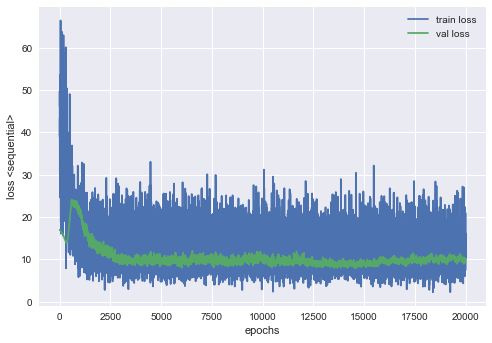

In [10]:
# loss plot
mpl.style.use('seaborn')
plt.plot(losses,label='train loss')
plt.plot(losses_val,label='val loss')
plt.xlabel('epochs')
plt.ylabel('loss <sequential>')
plt.legend()
plt.show()

100%|██████████| 10/10 [00:00<00:00, 4274.23it/s]


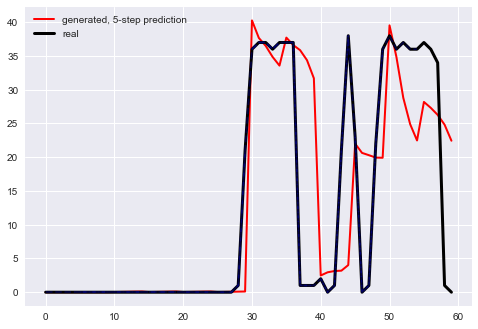

In [11]:
# Reconstruct a specific part of the train data using trained NN
n_reconstruction = 10
n_offset = 71000
X_sm_1[X_sm_1=='?'] = 0
X_sm_1 = X_sm_1.reshape((X_sm_1.shape[0],1)).astype(np.float32)
seq_model = seq_model.to("cpu")
for i in (t:=trange(n_reconstruction)):
    inp = X_sm_1[n_offset+out_size*i:n_offset+in_size+out_size*i,:].T
    inp_idx = np.array([[x for x in range(out_size*i,in_size+out_size*i)]])
    next = X_sm_1[n_offset+in_size+out_size*i:n_offset+in_size+out_size*(i+1),:]
    if i == 0:
        out = seq_model(torch.from_numpy(inp)).detach().numpy()
        gen_data = np.hstack((inp,out[0,:out_size].reshape((1,out_size))))
        real_data = np.hstack((inp,next.reshape((1,out_size))))
        InpStack = inp
        InpIdxStack = inp_idx
    else:
        out = seq_model(torch.from_numpy(inp)).detach().numpy()
        gen_data = np.hstack((gen_data,out[0,:out_size].reshape((1,out_size))))
        real_data = np.hstack((real_data,next.reshape((1,out_size))))
        InpStack = np.vstack((InpStack,inp))
        InpIdxStack = np.vstack((InpIdxStack,inp_idx))
# plot
mpl.style.use('seaborn')
plt.plot(gen_data.reshape((gen_data.shape[1],)),"r",linewidth=2)
plt.plot(real_data.reshape((real_data.shape[1],)),"k",linewidth=3)
plt.plot(InpIdxStack.T,InpStack.T,"b--",alpha=0.25)
plt.legend(['generated, 5-step prediction','real'])
plt.show()   

In [12]:
# Now we try prediction using LSTM

# first define a new LSTM class (different from pytorch original LSTM())
# source: https://towardsdatascience.com/pytorch-lstms-for-time-series-data-cd16190929d7
class LSTM2(nn.Module):
    def __init__(self, hidden_layers=64):
        super(LSTM2, self).__init__()
        self.hidden_layers = hidden_layers
        # lstm1, lstm2, linear are all layers in the network
        self.lstm1 = nn.LSTMCell(1, self.hidden_layers)
        self.lstm2 = nn.LSTMCell(self.hidden_layers, self.hidden_layers)
        self.linear = nn.Linear(self.hidden_layers, 1)
        
    def forward(self, y, future_preds):
        outputs, n_samples = [], y.size(0)
        h_t = torch.zeros(n_samples, self.hidden_layers, dtype=torch.float32).to(device)
        c_t = torch.zeros(n_samples, self.hidden_layers, dtype=torch.float32).to(device)
        h_t2 = torch.zeros(n_samples, self.hidden_layers, dtype=torch.float32).to(device)
        c_t2 = torch.zeros(n_samples, self.hidden_layers, dtype=torch.float32).to(device)
        
        for input_t in y.split(1, dim=1):
            # N, 1
            h_t, c_t = self.lstm1(input_t, (h_t, c_t)) # initial hidden and cell states
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2)) # new hidden and cell states
            output = self.linear(h_t2) # output from the last FC layer
            outputs.append(output)
            
        for i in range(future_preds):
            # this only generates future predictions if we pass in future_preds>0
            # mirrors the code above, using last output/prediction as input
            h_t, c_t = self.lstm1(output, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs.append(output)
        # transform list to tensor    
        outputs = torch.cat(outputs, dim=1)
        return outputs

In [13]:
# Chunk up the data into slices
chunk_max_size = 100
in_seq_size = 60
future_pred_size = chunk_max_size - (in_seq_size+1)
val_samples = 1000

count = 0
total_size = len(X_sm_1_list)
X_raw = []
while(chunk_max_size*(count+1) < total_size):
    w = X_sm_1_list[chunk_max_size*count:chunk_max_size*(count+1)]
    X_raw.append(w)
    count += 1
X_raw = np.array(X_raw)

In [14]:
# remove unwanted charachters like ?
X_train = clean_np(X_raw[val_samples:,:in_seq_size],['?'])
Y_train = clean_np(X_raw[val_samples:,1:],['?'])
X_val = clean_np(X_raw[:val_samples,:in_seq_size],['?'])
Y_val = clean_np(X_raw[:val_samples,1:],['?'])

# convert to tensor
X_train = torch.from_numpy(X_train).to(device)
Y_train = torch.from_numpy(Y_train).to(device)
X_val = torch.from_numpy(X_val).to(device)
Y_val = torch.from_numpy(Y_val).to(device)

In [15]:
# train the lstm

# model 
model = LSTM2().to(device)

# params
optim2 = optim.SGD(model.parameters(), lr=1e-3)
n_epochs = 20000
loss_fn = nn.MSELoss()
losses = []
losses_val = []
BS = 128 # batch size


# training loop
for i in (t:=trange(n_epochs)):
    samp = np.random.randint(0,X_train.shape[0],(BS))
    X = X_train[samp,:]
    Y = Y_train[samp]
    out = model(X,future_pred_size)
    loss = loss_fn(out,Y)
    optim2.zero_grad()
    loss.backward()
    optim2.step()
    t.set_description('loss %.3f' % (loss.item()))
    losses.append(loss.item())
    # calculate validation losses
    losses_val.append(loss_fn(model(X_val,future_pred_size),Y_val).item())

loss 12.939: 100%|██████████| 20000/20000 [44:09<00:00,  7.55it/s] 


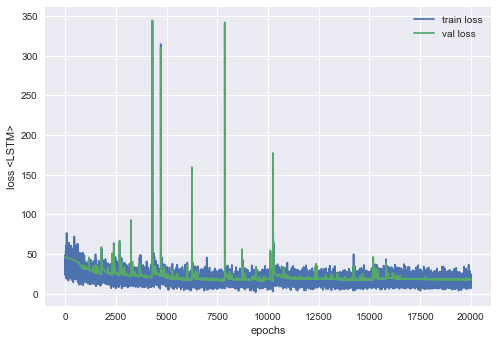

In [16]:
# loss plot
mpl.style.use('seaborn')
plt.plot(losses,label='train loss')
plt.plot(losses_val,label='val loss')
plt.xlabel('epochs')
plt.ylabel('loss <LSTM>')
plt.legend()
plt.show()